## DDIM Sensitivity Analysis

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from smalldiffusion import (
    TimeInputMLP, 
    # ScheduleLogLinear, 
    training_loop, 
    samples,
    DatasaurusDozen, 
    Swissroll, 
    ModelMixin
)
from tqdm import tqdm
from torch import nn

import math
from typing import Optional, Union, Tuple
from itertools import pairwise

def plot_batch(batch):
    batch = batch.cpu().numpy()
    plt.scatter(batch[:,0], batch[:,1], marker='.'); plt.axis('square')

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [2]:
from types import SimpleNamespace
from typing import Optional, Union, Tuple

class Schedule:
    '''Diffusion noise schedules parameterized by sigma'''
    def __init__(self, sigmas: torch.FloatTensor):
        self.sigmas = sigmas

    def __getitem__(self, i) -> torch.FloatTensor:
        return self.sigmas[i]

    def __len__(self) -> int:
        return len(self.sigmas)

    def sample_sigmas(self, steps: int) -> torch.FloatTensor:
        '''Called during sampling to get a decreasing sigma schedule with a
        specified number of sampling steps:
          - Spacing is "trailing" as in Table 2 of https://arxiv.org/abs/2305.08891
          - Includes initial and final sigmas
            i.e. len(schedule.sample_sigmas(steps)) == steps + 1
        '''
        indices = list((len(self) * (1 - np.arange(0, steps)/steps))
                       .round().astype(np.int64) - 1)
        return self[indices + [0]]

    def sample_batch(self, x0: torch.FloatTensor) -> torch.FloatTensor:
        '''Called during training to get a batch of randomly sampled sigma values
        '''
        batchsize = x0.shape[0]
        return self[torch.randint(len(self), (batchsize,))].to(x0)

def sigmas_from_betas(betas: torch.FloatTensor):
    return (1/torch.cumprod(1.0 - betas, dim=0) - 1).sqrt()

# Simple log-linear schedule works for training many diffusion models
class ScheduleLogLinear(Schedule):
    def __init__(self, N: int, sigma_min: float=0.02, sigma_max: float=10):
        super().__init__(torch.logspace(math.log10(sigma_min), math.log10(sigma_max), N))


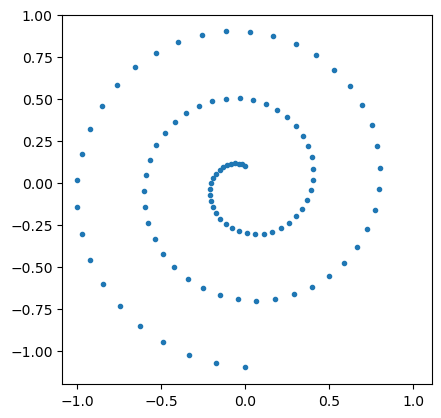

In [3]:
# Try replacing dataset with 'dino', 'bullseye', 'h_lines', 'x_shape', etc. 
# dataset = DatasaurusDozen(csv_file='../datasets/DatasaurusDozen.tsv', dataset='dino')
# Or use the SwissRoll dataset
batch_size=2130
dataset = Swissroll(np.pi/2, 5*np.pi, 100)
loader = DataLoader(dataset, batch_size=batch_size)
plot_batch(next(iter(loader)))

In [4]:
schedule = ScheduleLogLinear(N=200, sigma_min=0.01, sigma_max=10)
# plt.plot(schedule.sigmas)

In [5]:
device='cpu' #Faster for toy model?
epochs=15000 #15000
lr=1e-3 #1e-3
model = TimeInputMLP(hidden_dims=(16,128,128,128,128,16))
model.to(device);
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
loss_func=nn.MSELoss()

losses=[]
for _ in tqdm(range(epochs)):
    for x0 in loader:
        model.train()
        optimizer.zero_grad()
        
        eps = torch.randn_like(x0)
        sigma = schedule.sample_batch(x0)

        noised_data=x0 + sigma.unsqueeze(-1) * eps
        yhat=model(noised_data.to(device), sigma.to(device), cond=False) #lose usqueeze here for images?
        loss=loss_func(eps.to(device), yhat)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

100%|█████████████████████████████| 15000/15000 [00:47<00:00, 312.93it/s]


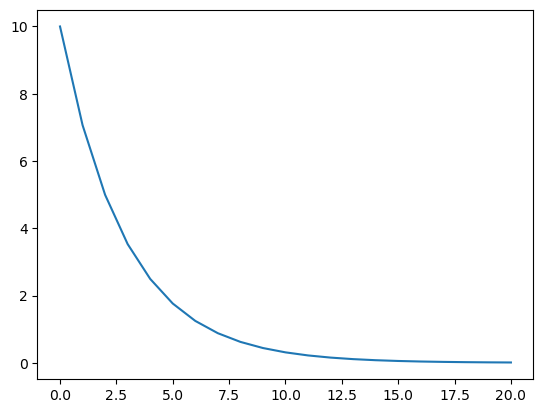

In [16]:
plt.plot(sigmas)

In [25]:
model.to(device);
sigmas=schedule.sample_sigmas(20)
xt_history=[]
step_sizes=[]
with torch.no_grad():
    model.eval();
    xt=torch.randn((batch_size,) + model.input_dims)*sigmas[0] #Scaling by sigma here matters a lot - why is that???

    for i, (sig, sig_prev) in enumerate(pairwise(sigmas)):
        eps=model.forward(xt, sig.to(xt), cond=None)
        xt = xt - (sig - sig_prev) * eps #
        step_sizes.append(sig - sig_prev)
        xt_history.append(xt.numpy())

xt_history=np.array(xt_history)

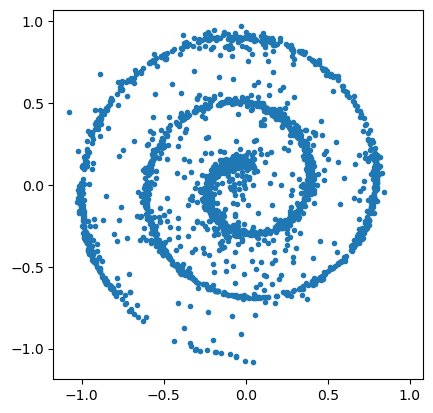

In [26]:
plot_batch(xt)

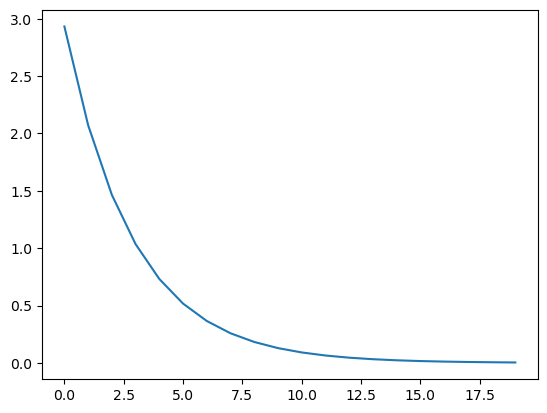

In [29]:
plt.plot(step_sizes)

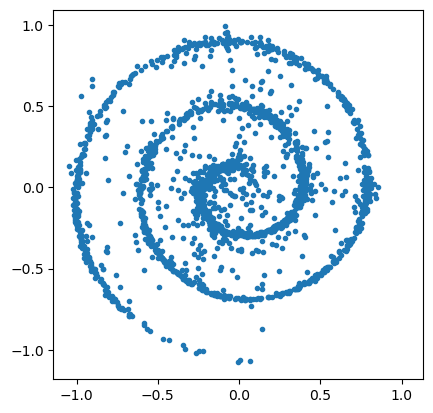

In [7]:
plot_batch(xt)

In [30]:
model.to(device);
gam=1
mu=0.5
cfg_scale=0.0
cond=None
sigmas=schedule.sample_sigmas(20)
xt_history=[]
ddpm_step_sizes=[]
with torch.no_grad():
    model.eval();
    xt=torch.randn((batch_size,) + model.input_dims)*sigmas[0] #Scaling by sigma here matters a lot - why is that???

    for i, (sig, sig_prev) in enumerate(pairwise(sigmas)):
        eps_prev, eps = eps, model.predict_eps_cfg(xt, sig.to(xt), cond, cfg_scale)
        # eps_av = eps * gam + eps_prev * (1-gam)  if i > 0 else eps
        sig_p = (sig_prev/sig**mu)**(1/(1-mu)) # sig_prev == sig**mu sig_p**(1-mu)
        eta = (sig_prev**2 - sig_p**2).sqrt()
        xt = xt - (sig - sig_p) * eps + eta * model.rand_input(xt.shape[0]).to(xt)
        ddpm_step_sizes.append(sig - sig_p)
        xt_history.append(xt.numpy())

xt_history=np.array(xt_history)

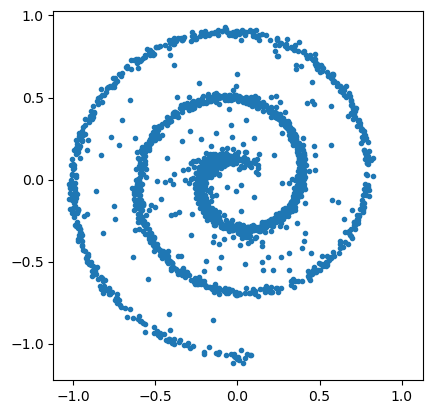

In [31]:
plot_batch(xt)

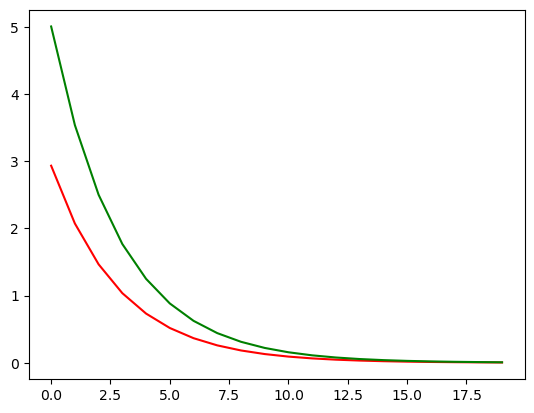

In [33]:
plt.plot(step_sizes, 'r')
plt.plot(ddpm_step_sizes, 'g')

So smaller steps - interesting...that kinda makes sense. With ddpm step sizes we "overshoot" -> that's an interesting juxtoposition.